# Импорт



In [80]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

In [81]:
import os
import sys
import re
import time
import pandas as pd
import numpy as np
import math

from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cosine 

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten, Input, concatenate, Reshape
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import tensorflow_hub as hub
import tensorflow_text as text

from matplotlib import pyplot as plt

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
PATH = '/content/drive/MyDrive/Colab Notebooks/HACKATHONS/Видеопереворот/Поиск/files/'

# Загрузим данные

In [84]:
df_data = pd.read_csv(PATH + 'data.csv')

In [85]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16214 entries, 0 to 16213
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 16214 non-null  int64  
 1   fulltitle           16214 non-null  object 
 2   vector_type         16214 non-null  int64  
 3   duration            16214 non-null  float64
 4   like_proportion     16214 non-null  float64
 5   dislike_proportion  16214 non-null  float64
 6   comment_proportion  16214 non-null  float64
 7   upload_date         16214 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1013.5+ KB


In [87]:
vectors = np.load(PATH + 'vectors.npy')

In [88]:
vectors.shape

(16214, 768)

# BERT

## Загрузка

In [89]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4", trainable=True)

## Инициализация слоев BERT
В приведенном ниже коде мы создаем входной слой, используя tf.keras.layers.Input метод. Мы будем использовать в **preprocessed_text** качестве входных данных для этого слоя.

Затем **bert_encoder** функция преобразует предварительно обработанный текст в embadding векторы. Это будет выход этого слоя. Затем **outputs** они будут переданы в слои нейронной сети.

In [90]:
text_input = Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

## Проверим работу

In [91]:
p_text = bert_preprocess(['text'])
v = bert_encoder(p_text)
v['pooled_output'][0]

<tf.Tensor: shape=(768,), dtype=float32, numpy=
array([ 2.70360768e-01, -1.51426062e-01,  2.02479199e-01,  1.36259899e-01,
       -1.11353837e-01,  2.72155315e-01,  1.81260243e-01,  2.49675810e-01,
       -4.55122590e-01,  2.98245370e-01,  2.79915277e-02, -6.94648996e-02,
       -1.89138651e-01, -1.81659594e-01,  3.23842242e-02, -1.17484033e-01,
        4.35242593e-01,  8.08974821e-03, -1.77941412e-01, -4.19278622e-01,
       -9.99817014e-01, -2.44626284e-01, -3.81946653e-01, -2.06391692e-01,
       -3.17561030e-01,  1.76367819e-01, -6.06936403e-02,  2.72821009e-01,
        3.63530308e-01, -1.30346343e-01,  3.63765284e-04, -9.99835134e-01,
        4.42686796e-01,  5.91137767e-01,  2.33705372e-01, -8.11596885e-02,
        1.85112208e-01,  1.85093611e-01,  3.22860420e-01, -3.63657415e-01,
        2.37818714e-02, -1.49479315e-01,  1.35587722e-01,  1.46379009e-01,
        1.47331789e-01, -3.42430741e-01, -8.86014625e-02,  6.14466034e-02,
       -3.10207456e-01,  5.89234270e-02, -1.73557159

# Ближайшие соседи

In [92]:
neigh = NearestNeighbors(n_neighbors=30, n_jobs=-1, metric='cosine') 
neigh.fit(vectors)

NearestNeighbors(metric='cosine', n_jobs=-1, n_neighbors=30)

# Протестируем

In [93]:
# Ближайшие соседи
def get_search(df_key, neigh, text):
  # Получим вектор для текста
  text = re.sub(r'[^\w\d\s\-]', '', text)
  text = re.sub(r'\s{2,}', ' ', text)
  vector = bert_encoder(bert_preprocess([text]))['pooled_output'][0]

  # Получим ближайших соседей
  res = neigh.kneighbors([vector], return_distance=True)
  idx = res[1][0]
  nearest = df_key.iloc[idx]
  return nearest['fulltitle'].unique()[0:10]

### Тесты

### С вхождением ключевых слов

In [94]:
text = "Маша и медведь"
search = get_search(df_data, neigh, text)
print(f'ИСКОМАЯ ФРАЗА: "{text}"')
print()
print('РЕЗУЛЬТАТ:')
for i in range(10):
  print(search[i])

ИСКОМАЯ ФРАЗА: "Маша и медведь"

РЕЗУЛЬТАТ:
Маша и Медведь - Фокус-Покус (Трейлер 4)
Маша и Медведь. Ловись рыбка. Какие замечательные червячки!
Маша и Медведь (Masha and The Bear) - Маша плюс каша (17 Серия)
Маша и Медведь - "Новогодняя песенка" (Раз, два, три! Елочка, гори!)
Маша и Медведь - Нынче все наоборот🔁 (Серия 38)
Маша и Медведь - Песня “Сладкая жизнь” (Сладкая жизнь)
Маша и Медведь (Masha and The Bear) - Следы невиданных зверей (4 Серия)
Маша и Медведь - 🎩 Машины Наряды 💃
Маша и Медведь 👱‍♀️🙈 Ох и заварила я кашу... 🤣 Сборник серий про Машу 🎬
Маша и Медведь - Следы невиданных зверей🐾 (Серия 4)


In [95]:
text = "Щенячий патруль"
search = get_search(df_data, neigh, text)
print(f'ИСКОМАЯ ФРАЗА: "{text}"')
print()
print('РЕЗУЛЬТАТ:')
for i in range(10):
  print(search[i])

ИСКОМАЯ ФРАЗА: "Щенячий патруль"

РЕЗУЛЬТАТ:
Щенячий патруль | Самый лучший день! - часть 3 | Nick Jr. Россия
Щенячий патруль | Лучший пожарник | Nick Jr. Россия
Щенячий патруль | Пасха уже тут | Nick Jr. Россия
Щенячий патруль | Лучшие зимние приключения! ❄️ | Nick Jr. Россия
Щенячий патруль | Новогодняя ёлка | Nick Jr. Россия
Щенячий патруль | В поиске рюкзака | Nick Jr. Россия
Щенячий патруль | Щенки и котята-шалуны 🐱 | Nick Jr. Россия
САМЫЙ УЖАСНЫЙ ЛЕТНИЙ ЛАГЕРЬ! Прикольный баг с монахиней! The Evil Nun🎭
МУЛЬТЯШНЫЙ КОТ ПРОТИВ СЛЕНДЕРМЕНА, ОНО ПЕННИВАЙЗ, ДЖЕЙСОН ВУРХИЗ, МАЙКЛ МАЙЕРС, ФРЕДДИ, КОЖАНОЕ ЛИЦО
Купили Артиллерийский Тягач  - Легкий 1958 года


### LSI фразы, без вхождения ключевых слов, но похожие по смыслу

In [96]:
text = "Детские мультфильмы"
search = get_search(df_data, neigh, text)
print(f'ИСКОМАЯ ФРАЗА: "{text}"')
print()
print('РЕЗУЛЬТАТ:')
for i in range(10):
  print(search[i])

ИСКОМАЯ ФРАЗА: "Детские мультфильмы"

РЕЗУЛЬТАТ:
Сборник серий об изобретениях. Смешарики. Пинкод | Познавательные мультфильмы
Титаны древности - Смешарики. ПИН - код | Познавательные мультфильмы
Солнечно Зайчики - Желторотики | Забавные мультфильмы для детей | WildBrain
Три Кота | Сборник сладких серий | Мультфильмы для детей
Три Кота | Урчащие животы | Мультфильмы для детей | Новая серия 154
Три Кота | Сборник уморительных серий | Мультфильмы для детей 2020
Три Кота | Автобус 🚌  Мультфильмы для детей | Премьера новой серии №166
В начале было слово - Смешарики 2D | Мультфильмы для детей
Как стать звездой - Смешарики 2D | Мультфильмы для детей
Добро,зло и девочки - Смешарики 2D | Мультфильмы для детей


### Фразы с ошибочным написанием

In [97]:
text = "Даша и Ведведь"
search = get_search(df_data, neigh, text)
print(f'ИСКОМАЯ ФРАЗА: "{text}"')
print()
print('РЕЗУЛЬТАТ:')
for i in range(10):
  print(search[i])

ИСКОМАЯ ФРАЗА: "Даша и Ведведь"

РЕЗУЛЬТАТ:
Маша и Медведь - 🎩 Машины Наряды 💃
Маша и Медведь - Не царское дело!  🔱 (Трейлер)
Маша и Медведь 👱‍♀️👧 Маша на спорте! ⚽🏅 Коллекция лучших спортивных серий про Машу 🎬
Маша и Медведь - "Новогодняя песенка" (Раз, два, три! Елочка, гори!)
Маша и Медведь - Песня “Сладкая жизнь” (Сладкая жизнь)
Маша и Медведь - Следы невиданных зверей🐾 (Серия 4)
Маша и Медведь 👱‍♀️🙈 Ох и заварила я кашу... 🤣 Сборник серий про Машу 🎬
ПЕСЕНКА ДРУЗЕЙ 👧 🐻 Мультфильм Маша и Медведь 🤩
Маша и Медведь 💥 НОВАЯ СЕРИЯ! 💥Кушать подано😋🪴 Коллекция мультиков для детей про Машу
Маша и Медведь - 🤡 Детский Праздник! 👧🏻👶🧒


## Выводы 
Всё работает отлично, система подбирает ответы по смыслу. Даже если написать слова с ошибкой - поисковая система на основе нейросети BERT - подберёт правильный ответ. 

Так же в примере для LSI фраз - видно, что система подбирает ответы близкие по смыслу поисковой фразе, даже без вхождения ключевых слов. Такого невозможно добиться при поиске по ключевым фразам.

 ==============================================================================

# Улучшаем модель, добавляем признаки полученные из видео
А так же дополнительные признаки, поученные при обработки данных - тип ngram

Наша модель прекрасно ищет по смыслу, но нам бы хотелось учитывать и другие факторы - насколько это видео нравиться людям, насколько это видео вызывает желание написать комментарий и др. Нам бы таж же хотелось бы, что бы новые видео ранжировались лучше, а популярные были выше непопулярных. 

Как это сделать? 

На этапе подготовки данных мы извлекли эти признаки и теперь можем их использовать как коэффициенты в функциях для расчёта веса признака, на которые мы умножим полученную косинусную близость.

## Функции

In [98]:
# Обработка признаков
def get_score(row, cos):
  k_ngram = 0.93 + row['vector_type']/100  # ngram
  k_duration = 0.7 + row['duration'] * 0.1  # duration
  k_like = 1 + row['like_proportion'] * 20  # like_proportion
  k_dislike = 1 - row['dislike_proportion'] * 20  # dislike_proportion
  k_comment = 1 - row['comment_proportion'] * 20  # comment_proportion
  delta_days = (df_data['upload_date'].max() - row['upload_date'] + 1)/86400
  k_date = 1 - math.log10(delta_days)*0.05
  score = (1 - cos) * k_ngram * k_duration * k_like * k_dislike * k_comment * k_date
  return score


# Ближайшие соседи
def get_neigh(df_key, neigh, text):
  # Получим вектор для текста
  text = re.sub(r'[^\w\d\s\-]', '', text)
  text = re.sub(r'\s{2,}', ' ', text)
  vector = bert_encoder(bert_preprocess([text]))['pooled_output'][0]

  # Получим ближайших соседей
  res = neigh.kneighbors([vector], return_distance=True)

  score_list = []
  for i in range(len(res[0][0])):
    idx = res[1][0][i]
    row = df_key.iloc[idx]
    cos = res[0][0][i]
    score = get_score(row, cos)
    score_list.append([idx, row['fulltitle'], score])

  df = pd.DataFrame(score_list, columns=['idx', 'fulltitle', 'score'])
  df_sort = df.sort_values(by='score', ascending=False)  # ascending=False для сортировки по убыванию   
  return df_sort['fulltitle'].unique()[0:10]


## Тест

In [99]:
text = "Маша и медведь"
search = get_neigh(df_data, neigh, text)
print(f'ИСКОМАЯ ФРАЗА: "{text}"')
print()
print('РЕЗУЛЬТАТ:')
for i in range(10):
  print(search[i])

ИСКОМАЯ ФРАЗА: "Маша и медведь"

РЕЗУЛЬТАТ:
Маша и Медведь 💥 НОВАЯ СЕРИЯ! 💥Кушать подано😋🪴 Коллекция мультиков для детей про Машу
Маша и Медведь 🏒 Вот такой хоккей! 🏒  Сборник 29 🎬  30 минут сборник мультиков для детей
Маша и Медведь 👱‍♀️🙈 Ох и заварила я кашу... 🤣 Сборник серий про Машу 🎬
Маша и Медведь 👱‍♀️👧 Маша на спорте! ⚽🏅 Коллекция лучших спортивных серий про Машу 🎬
Маша и Медведь - 🤡 Детский Праздник! 👧🏻👶🧒
Маша и Медведь - 🎩 Машины Наряды 💃
Пьяная мать с годовалым ребенком в Апатитах сопротивляется полиции
Маленькая Вера и Медведь влог - Играем в Бизиборд для детей малышей
Маша и Медведь - Следы невиданных зверей🐾 (Серия 4)
Маша и Медведь - Спи, моя радость, усни! (Серия 62)


# Выводы
После добавления весовых коэффициентов - выдача изменилась - поиск стал более гибким и стал выдавать приоритет более новым роликам, но потерял некотору долю релевантности.

# Дальнейшее развите

## 1. Получение данных о релевантности поисковой выдачи

Ручная установка коэффициентов допустима в демонстрационной версии для того, что бы было проще понять принцип работы, но не допустима в рабочей.

В рабочей версии необходимо подбирать веса с помощью нейросети.

Но тут возникают проблемы - у нас есть входные данные "x", но нет выходных - данных "y", которые бы служили критерием качества оценки поиска.

РЕШЕНИЕ:

При выполнении посетителем поиска - учитывать следующие действия: быстрый клик, долгий клик, последний клик, где:

*  **быстрый клик** - действи при котором пользователь посмотрел результат из поиска и продолжил просмотр далее - что говорит нам о том, что результат не v пользователя, присваиваем вес 0

* **длинный клик** - действие при котором посетитель заинтересовался, но ответ его не устроил до конца

*  **последний клик** - это клик после которого пользователь перестал искать далее. Обычно такая ситуация говорит нам о том, что пользователь нашёл то, что ему нужно и прекратил дальнейший поиск, присваиваем вес = 1

На этих действиях пользователя и будем обучать нейросеть.

Похожий подход использует Гугл-поиск, но их подход запатентован. Надо решать юридические моменты.

## 2. Добавить дополнительные коэффициенты, сделать их подбор нейросетью

## 3. Собирать и добавлять в модель признаки не только видео, но и пользователя.
Это может быть:

*   пол
*   возраст
*   регион
*   образование
*   день недели просмотра видео
*   время суток просмотра видео
*   средняя длительность просмотра видео
*   наличие скролла и др.



## 4. Собрать модель подбора коэффициентов на основе метода 2х башен
Разделим и отдельно подадим признаки для видео и для пользователя в разные башни модели, построенной по методу 2х башен, по аналогии с TFRS

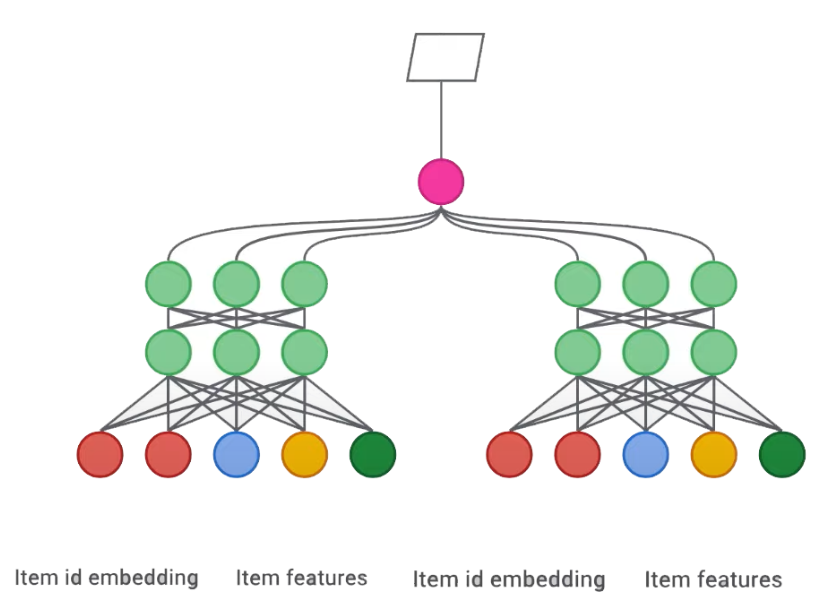

# 5. Создать федеративную поисковую систему.
Реализуем расчёт модели башни пользователя на устройстве пользователя (смартфон, планшет):

*   защищаем персональные данные пользователя
*   снижаем нагрузку на систему

